In [2]:
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Qibo libraries
import qibo
from qibo import hamiltonians as ham, matrices as m
from qibo import gates, models
from qibo.models import Circuit
from qibo.models.utils import matrix_to_pauli_operators
import numpy as np

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
def ising_chain_ham_qibo(n, gam):
    
    # n = number of spin positions
    # gam = transverse field parameter
    
    for i in range(n):
        vecX = [m.I] * n
        vecZ = [m.I] * n
        vecX[i] = m.X
        vecZ[i] = m.Z
        
        if i == n - 1:
            vecX[0] = m.X
        else:
            vecX[i+1] = m.X

        auxX = vecX[0]
        auxZ = vecZ[0]
        
        for a in vecX[1:n]:
            auxX = np.kron(auxX, a)
        for b in vecZ[1:n]:
            auxZ = np.kron(auxZ, b)
            
        if i == 0:
            H = (auxX) + (gam * auxZ)
        else:
            H = H + (auxX) + (gam * auxZ)

    return ham.Hamiltonian(n, H)

In [13]:
# Create a Ising Hamiltonian to minimize with VQE and Rotosolve optimizer
n = 4 # número de qubits
gam = 0.3

H = ising_chain_ham_qibo(n, gam) # Creamos el Hamiltoniano

# Pauli decomposition operators
print("Hamiltonian matrix in Pauli Operators")
print("-------------------------------------")
matrix_to_pauli_operators(H.matrix)

Hamiltonian matrix in Pauli Operators
-------------------------------------


{'IIIZ': 0.3,
 'IIXX': 1.0,
 'IIZI': 0.29999999999999993,
 'IXXI': 1.0,
 'IZII': 0.3,
 'XIIX': 1.0,
 'XXII': 1.0,
 'ZIII': 0.29999999999999993}

In [5]:
nqubits = 4
nlayers = 3

# Create variational ansatz circuit Twolocal
ansatz = models.Circuit(nqubits)
for l in range(nlayers):
    
    ansatz.add((gates.RY(q, theta=0) for q in range(nqubits)))
    
    for i in range(nqubits - 3):
        ansatz.add(gates.CNOT(i, i+1))
        ansatz.add(gates.CNOT(i, i+2))
        ansatz.add(gates.CNOT(i+1, i+2))
        ansatz.add(gates.CNOT(i, i+3))
        ansatz.add(gates.CNOT(i+1, i+3))
        ansatz.add(gates.CNOT(i+2, i+3))
    
ansatz.add((gates.RY(q, theta=0) for q in range(nqubits)))

print(ansatz.draw())

q0: ─RY─o─o───o─────RY─o─o───o─────RY─o─o───o─────RY─
q1: ─RY─X─|─o─|─o───RY─X─|─o─|─o───RY─X─|─o─|─o───RY─
q2: ─RY───X─X─|─|─o─RY───X─X─|─|─o─RY───X─X─|─|─o─RY─
q3: ─RY───────X─X─X─RY───────X─X─X─RY───────X─X─X─RY─


In [6]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'exp_val': [],
}

# Callback function for intermediate values on each epoch
def callback(theta_optimal, expectation_vals, nevals):

    intermediate_info['nfev'].append(nevals)
    intermediate_info['parameters'].append(theta_optimal)
    intermediate_info['exp_val'].append(expectation_vals)

# Create VQE model
vqe = models.VQE(ansatz, H)

# Optimize starting from a random guess to set the initial parameters
nparams = 16
initial_parameters = np.random.random(nparams) # valor inicial

# Rotosolve options
options = {
            'max_steps': 50,
            'step_size' : 1,
            'num_params' : nparams,
          }

result, params, extra = vqe.minimize(initial_parameters,
                                     method='rotosolve', # select rotosolve as optimizer
                                     callback = callback,
                                     options = options,
                                     compile=False)

Rotosolve circuit optimization steps
Step 0. Current expectation value: -3.03873721
Step 1. Current expectation value: -3.97905384
Step 2. Current expectation value: -4.06583969
Step 3. Current expectation value: -4.07848641
Step 4. Current expectation value: -4.08470700
Step 5. Current expectation value: -4.08728467
Step 6. Current expectation value: -4.08845009
Step 7. Current expectation value: -4.08906645
Step 8. Current expectation value: -4.08943851
Step 9. Current expectation value: -4.08968468
Step 10. Current expectation value: -4.08985744
Step 11. Current expectation value: -4.08998328
Step 12. Current expectation value: -4.09007716
Step 13. Current expectation value: -4.09014833
Step 14. Current expectation value: -4.09020289
Step 15. Current expectation value: -4.09024506
Step 16. Current expectation value: -4.09027785
Step 17. Current expectation value: -4.09030348
Step 18. Current expectation value: -4.09032358
Step 19. Current expectation value: -4.09033939
Step 20. Curr

In [7]:
print("Results:")
print("--------")
print(result)

Results:
--------
[-3.038737205292245, -3.9790538368408153, -4.065839685813058, -4.078486414566324, -4.084706996031653, -4.087284668637121, -4.0884500938074515, -4.08906644742042, -4.089438513260871, -4.089684681920618, -4.089857440586877, -4.089983278232944, -4.090077160283121, -4.090148331749704, -4.090202892858727, -4.090245062046772, -4.090277854831312, -4.090303478663396, -4.090323577817086, -4.090339393147461, -4.090351870484646, -4.090361736451603, -4.090369552770637, -4.090375755895622, -4.090380686367952, -4.090384610821431, -4.090387738637457, -4.090390234651273, -4.0903922289096295, -4.090393824205234, -4.090395101921671, -4.090396126585533, -4.090396949423666, -4.090397611151143, -4.090398144161853, -4.090398574253463, -4.090398921988399, -4.090399203769472, -4.090399432691223, -4.090399619214688, -4.090399771702822, -4.090399896845817, -4.09039999999925, -4.090400085453213, -4.090400156646607, -4.090400216337957, -4.090400266741625, -4.090400309636489, -4.090400346452759, 

In [8]:
print("Optimized parameters:")
print("---------------------")
print(params)

Optimized parameters:
---------------------
[-3.13602680e+00 -3.12492212e+00 -6.36850577e-01  1.20331470e+00
 -6.33153753e+00 -8.14309799e-04 -4.79489693e+00 -6.54544028e+00
 -6.25124318e+00 -5.55432003e+00 -6.25630634e-01 -6.14356552e+00
 -4.91878090e+00 -5.28864417e+00 -1.44543406e-01  7.36755274e-01]


In [9]:
print("Execution summary:")
print("------------------")
print(extra)

Execution summary:
------------------
{'x': array([-3.13602680e+00, -3.12492212e+00, -6.36850577e-01,  1.20331470e+00,
       -6.33153753e+00, -8.14309799e-04, -4.79489693e+00, -6.54544028e+00,
       -6.25124318e+00, -5.55432003e+00, -6.25630634e-01, -6.14356552e+00,
       -4.91878090e+00, -5.28864417e+00, -1.44543406e-01,  7.36755274e-01]), 'fun': -4.090400406228879, 'exp_vals': [-3.038737205292245, -3.9790538368408153, -4.065839685813058, -4.078486414566324, -4.084706996031653, -4.087284668637121, -4.0884500938074515, -4.08906644742042, -4.089438513260871, -4.089684681920618, -4.089857440586877, -4.089983278232944, -4.090077160283121, -4.090148331749704, -4.090202892858727, -4.090245062046772, -4.090277854831312, -4.090303478663396, -4.090323577817086, -4.090339393147461, -4.090351870484646, -4.090361736451603, -4.090369552770637, -4.090375755895622, -4.090380686367952, -4.090384610821431, -4.090387738637457, -4.090390234651273, -4.0903922289096295, -4.090393824205234, -4.090395101

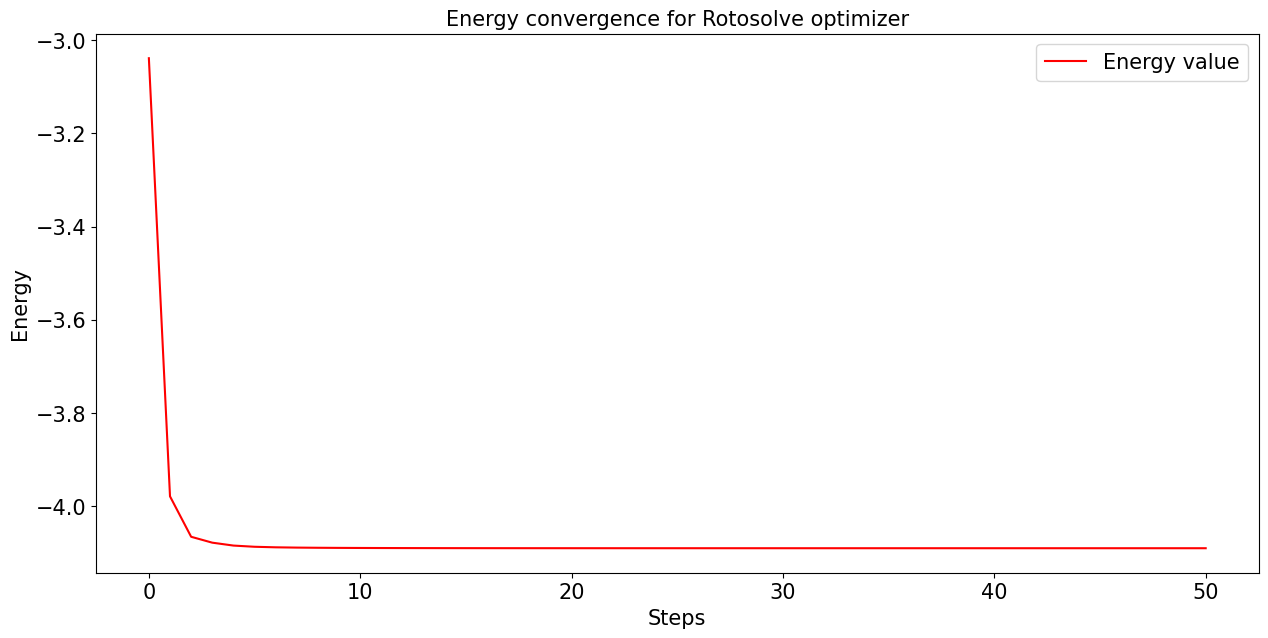

In [10]:
final_result = intermediate_info['exp_val']

fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(final_result)), final_result, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Rotosolve optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

In [11]:
print("Best energy result:", np.min(result))
print("Mean energy result:", np.mean(result))

Best energy result: -4.090400406228879
Mean energy result: -4.066562289657867
